# Load compound and activity data

In [ ]:
!pip install rdkit
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

SEED = 22


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Read data from previous talktorials
chembl_df = pd.read_csv(
    HERE / "/content/drive/My Drive/3.Thesis 2/Weekly tasks/Teachopen CADD/Training_bioactivities_data.csv",
    index_col=0,
)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()
# NBVAL_CHECK_OUTPUT

In [ ]:
print(chembl_df.columns)


In [ ]:
print(chembl_df.head())


In [ ]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

# Label compound

pIC50 = -log10(IC50)

IC50 describes the amount of substance needed to inhibit, in vitro, a process by 50% .

A common cut-off value to discretize pIC50 data is 6.3, which we will use for our experiment (refer to J. Med. Chem. (2017), 60, 474-485 and the corresponding notebook)

## Data labeling

In [ ]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 599
Number of inactive compounds: 237


In [ ]:
chembl_df.head()
# NBVAL_CHECK_OUTPUT

molecule_chembl_id                                             smiles  \
0      CHEMBL3966290  CN(C)CC[C@@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O...   
1      CHEMBL4111781  CCNC[C@@H]1COCCN1CC[C@H](CSc1ccccc1)Nc1ccc(S(=...   
2      CHEMBL3703616  CCN(CC)C[C@H]1COCCN1CC[C@H](CSc1ccccc1)Nc1ccc(...   
3      CHEMBL3703617  CCN(CC)C[C@@H]1COCCN1CC[C@H](CSc1ccccc1)Nc1ccc...   
4      CHEMBL3703599  CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...   

      pIC50  active  
0  9.522879     1.0  
1  9.522879     1.0  
2  9.522879     1.0  
3  9.522879     1.0  
4  9.522879     1.0

## Molecule encoding

In [ ]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [ ]:
compound_df = chembl_df.copy()

In [ ]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

molecule_chembl_id                                             smiles  \
0      CHEMBL3966290  CN(C)CC[C@@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O...   
1      CHEMBL4111781  CCNC[C@@H]1COCCN1CC[C@H](CSc1ccccc1)Nc1ccc(S(=...   
2      CHEMBL3703616  CCN(CC)C[C@H]1COCCN1CC[C@H](CSc1ccccc1)Nc1ccc(...   

      pIC50  active                                                 fp  
0  9.522879     1.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  9.522879     1.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  9.522879     1.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

# Machine Learning (ML)

## Helper functions

Helper function to plot customized ROC curves

In [ ]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

Helper function to calculate model performance.

In [ ]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

Helper function to fit a machine learning model on a random train-test split of the data and return the performance measures.

In [ ]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

## Preprocessing

Split the data (will be reused for the other models)

In [ ]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 668
Test data size: 168


## SVM

In [ ]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.93
Specificity: 0.72
AUC: 0.92


In [ ]:
# Append SVM model
models = [{"label": "Model_SVM", "model": model_SVM}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

# Cross calidation

## Helper Function

In [ ]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

## Cross validation

In [ ]:
N_FOLDS = 3

In [ ]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)

# Parameter

Sensitivity: 0.93
Specificity: 0.76
AUC: 0.93
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
Test Accuracy: 0.88
Test Sensitivity: 0.93
Test Specificity: 0.76
Test AUC: 0.93


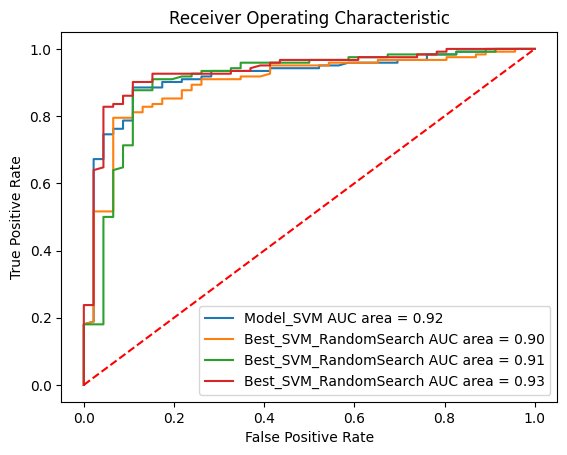

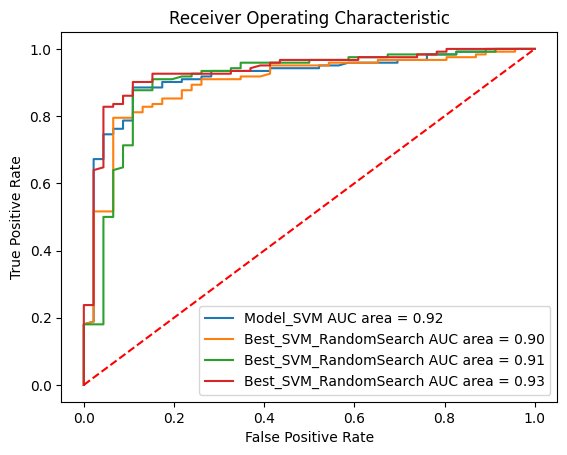

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter search space
param_grid_svm = {
  'C': [0.001, 0.01, 0.1, 1, 10, 100],
  'gamma': [0.01, 0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf', 'poly']
}

# Create a GridSearchCV object for SVM with defined hyperparameter grid
grid_search_svm = GridSearchCV(estimator=SVC(probability=True), param_grid=param_grid_svm, cv=5)

# Train the SVM model using GridSearchCV
grid_search_svm.fit(static_train_x, static_train_y)

# Get the best SVM model from GridSearchCV
best_model_svm = grid_search_svm.best_estimator_

# Evaluate the best model performance on the test set
accuracy, sens, spec, auc = model_performance(best_model_svm, static_test_x, static_test_y)

# Print the best hyperparameter combination found by Grid Search
print("Best Hyperparameters:", grid_search_svm.best_params_)

# Print test set performance metrics
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Sensitivity: {sens:.2f}")
print(f"Test Specificity: {spec:.2f}")
print(f"Test AUC: {auc:.2f}")

# Add the best model to the model list for plotting ROC curve
models.append({"label": "Best_SVM_GridSearch", "model": best_model_svm})

# Plot ROC curves for all models including the best Grid Search model
plot_roc_curves_for_models(models, static_test_x, static_test_y)
